# Check energyConsumption table
Getting the energyConsumption table in MySQL to determine if historical live data is correct enough.  
Checks:  
- hp energy consumption [0, 2500] Wh / hr, [0, 5000] for 8kW
- hp heat produced [-100, 8000] Wh / hr, [-100, 16000] for 8kW
- boiler heat produced [0, 37000] Wh / hr



In [2]:
import pandas as pd
import datetime
import pymysql
import os
from urllib.parse import urlparse

In [15]:
# get data from mysql or local
if os.environ['ENVIRONMENT'] == 'local':
    # load csv file
    df_energy = pd.read_csv('../data/20230918_energyConsumption.csv')
    df_hps = pd.read_csv('../data/20230918_hps.csv')

else:
    MYSQL_URL = os.environ['MYSQLPROD']
    parsed_mysql_url = urlparse(MYSQL_URL)

    try:
        connection = pymysql.connect(host=parsed_mysql_url.hostname,
                                    user=parsed_mysql_url.username,
                                    password=parsed_mysql_url.password,
                                    database=parsed_mysql_url.path[1:],
                                    port=parsed_mysql_url.port,
                                    autocommit=True)
        cursor = connection.cursor()
        if cursor.connection:
            # get energyConsumption
            cursor.execute('''SELECT * FROM energyConsumption''')
            fields = [field_md[0] for field_md in cursor.description]
            result = [dict(zip(fields,row)) for row in cursor.fetchall()]
            df_energy = pd.DataFrame(result)
            df_energy.to_csv('../data/20230918_energyConsumption.csv', index=False)
            
            # get cics and energy of hp
            cursor.execute('''SELECT id, installationId, numberOfHeatPumps FROM cic''')
            fields = [field_md[0] for field_md in cursor.description]
            result = [dict(zip(fields,row)) for row in cursor.fetchall()]
            df_hps = pd.DataFrame(result)
            df_hps.to_csv('../data/20230918_hps.csv', index=False)
    except:
        print("Error while connecting to MySQL")
    finally:
        cursor.close()
        connection.close()

    # convert to dataframe
   

    # dump data as csv
    # 

In [50]:
# merge data frames
df = pd.merge(df_energy, df_hps, how='left', 
              left_on='installationId', right_on='installationId')

# check for installationIds that could not be matched
print(len(df[df['id_y'].isnull()]['installationId'].unique()))

# calculate differences in counters
df['ts'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['installationId', 'ts'], inplace=True)
df['hpElectricDiff'] = df.groupby('installationId')['hpElectric'].diff()
df['hpHeatDiff'] = df.groupby('installationId')['hpHeat'].diff()
df['boilerHeatDiff'] = df.groupby('installationId')['boilerHeat'].diff()


38


In [52]:
# calculate differences per hour
df['timediff'] = df.groupby('installationId')['ts'].diff()
df['hpElectricDiffHr'] = df['hpElectricDiff'] / df['timediff'].dt.total_seconds()
df['hpHeatDiffHr'] = df['hpHeatDiff'] / df['timediff'].dt.total_seconds()
df['boilerHeatDiffHr'] = df['boilerHeatDiff'] / df['timediff'].dt.total_seconds()

In [53]:
# Find counters that violate the rules
df[df['hpElectricDiffHr'] < 0]['id_y'].unique()

array(['CIC-f3fa6423-a47d-58e0-a779-d581bcbf0863',
       'CIC-ac07e2be-6e22-57e5-815a-db5abfbeedb4',
       'CIC-f4914523-8f5a-5057-81b4-dbb97f2ac297',
       'CIC-50a48240-79c9-5448-9212-2c110c2ddda4',
       'CIC-8fbb1e20-1243-501c-8760-1ab4a42785c9',
       'CIC-6fa084b5-7bb9-5478-a4d6-1608c757978c',
       'CIC-8a59664f-f378-555a-a31a-88f268fb9556',
       'CIC-6d4c96eb-c547-5adc-baac-865717b29f1c',
       'CIC-ed47faab-fa4c-5a68-9a3d-aaeb9b21d877',
       'CIC-cbfcdc72-0de9-5f83-8afb-2120f894ee43',
       'CIC-d26ddcf0-1926-58b2-b3e7-a83ff7103a68',
       'CIC-5751fdf9-8473-586d-8bba-0e59564a8c45',
       'CIC-853c8648-b266-5ce7-bcb0-16dea7264234',
       'CIC-5c1ed3ae-4a6e-5c54-bb7b-6682ff5973ed',
       'CIC-e7d04807-ddee-558c-b74f-0dda4362949c',
       'CIC-7cec21cc-6ac6-5cee-94da-1db2bbf7741c',
       'CIC-a5a66d19-b620-5728-914b-b7ca48744766',
       'CIC-5d08dfe4-17bb-5a67-9b8d-4ff71cb4143c',
       'CIC-84b1a135-d9b7-5d74-9e59-637f6c07fc69',
       'CIC-d8ba5839-b00e-50ad-

<Axes: xlabel='ts'>

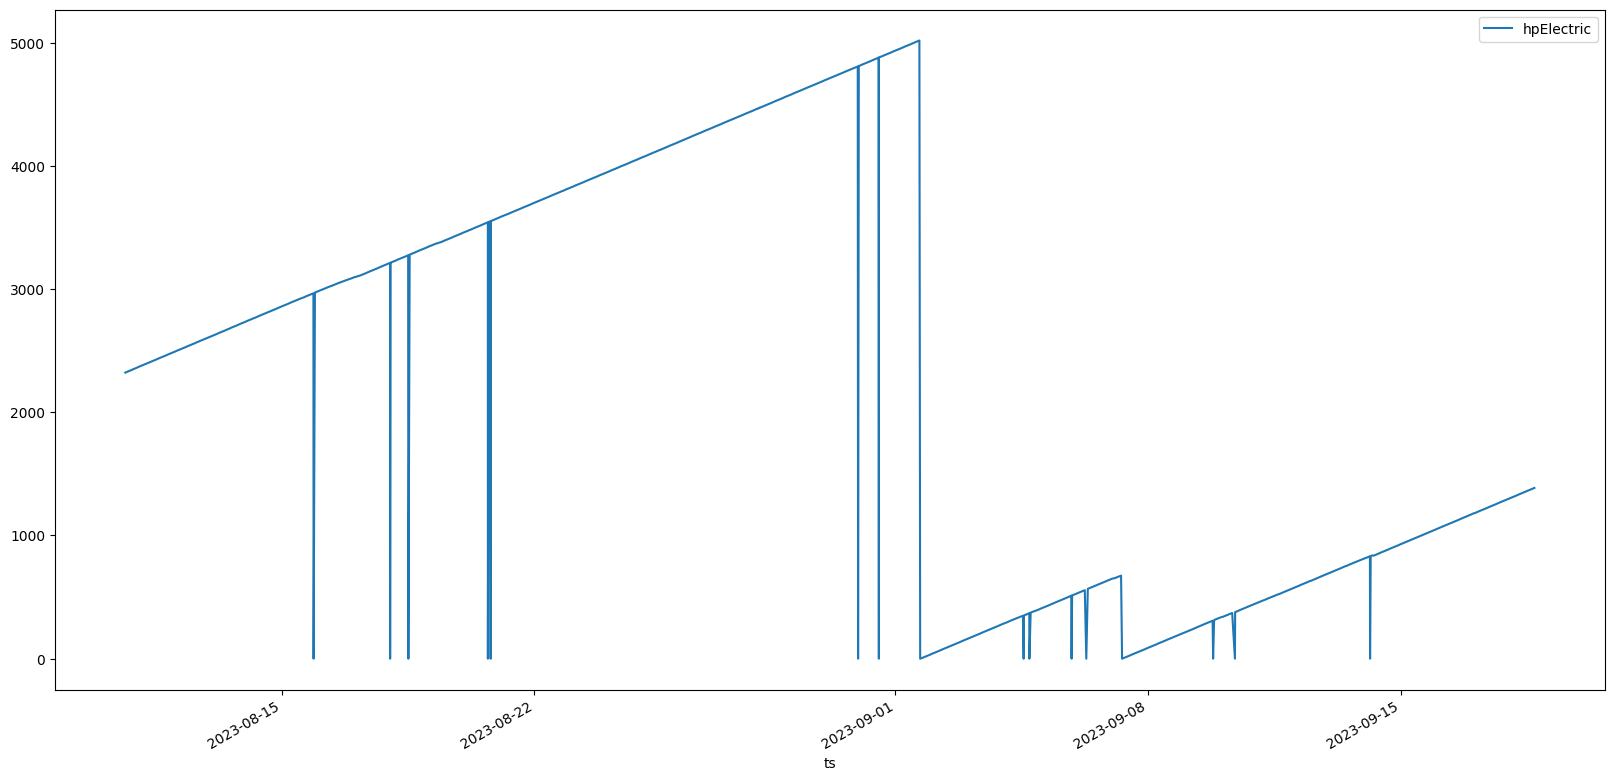

In [62]:
df[df['id_y']=='CIC-8a59664f-f378-555a-a31a-88f268fb9556'].plot(x='ts', y='hpElectric', figsize=(20,10))